In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import pickle

from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from learner.model import Loss, Frag2Mol
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.optim import Adam
from learner.trainer import Trainer
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn

/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Latent Space

In [3]:
config = pickle.load(open('RUNS/2022-08-08@20:20:02-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-08-08@20:20:02-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
#device = torch.device('cuda')
#model = model.to(device)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.


In [4]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 20...


In [5]:
model

Frag2Mol(
  (embedder): Embedding(90175, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=90175, bias=True)
  )
  (mlp): MLP(
    (layers): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
      (5): Sigmoid()
    )
  )
)

In [6]:
loader = dataset.get_loader()
#mu_stack = torch.empty((32,100))
#latent_output = torch.empty((32,100))
data_sample = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 103491. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
rnn2mean_weight

Parameter containing:
tensor([[ 0.0621, -0.0392,  0.0294,  ..., -0.0526,  0.0293, -0.0486],
        [ 0.0308, -0.0068,  0.0622,  ..., -0.0364, -0.0348,  0.0736],
        [ 0.0303, -0.0484, -0.0360,  ..., -0.0290, -0.0037,  0.0666],
        ...,
        [-0.0392, -0.0008, -0.0449,  ...,  0.0891,  0.0552, -0.0401],
        [ 0.0887, -0.0270,  0.0727,  ..., -0.0788, -0.0383, -0.0655],
        [-0.0337, -0.0394,  0.0813,  ...,  0.0655, -0.0147,  0.0148]],
       device='cuda:0', requires_grad=True)

In [8]:
for idx, (src, tgt, lengths, data) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred = model.forward(src, lengths)
    
    print(torch.all(rnn2mean_weight == model.encoder.rnn2mean.weight))
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
        pred_stack = pred
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_stack = torch.cat((pred_stack, pred), 0)
    print(len(mu_stack))
    if len(mu_stack) > 10000:
        break

tensor(True, device='cuda:0')
32
tensor(True, device='cuda:0')
64
tensor(True, device='cuda:0')
96
tensor(True, device='cuda:0')
128
tensor(True, device='cuda:0')
160
tensor(True, device='cuda:0')
192
tensor(True, device='cuda:0')
224
tensor(True, device='cuda:0')
256
tensor(True, device='cuda:0')
288
tensor(True, device='cuda:0')
320
tensor(True, device='cuda:0')
352
tensor(True, device='cuda:0')
384
tensor(True, device='cuda:0')
416
tensor(True, device='cuda:0')
448
tensor(True, device='cuda:0')
480
tensor(True, device='cuda:0')
512
tensor(True, device='cuda:0')
544
tensor(True, device='cuda:0')
576
tensor(True, device='cuda:0')
608
tensor(True, device='cuda:0')
640
tensor(True, device='cuda:0')
672
tensor(True, device='cuda:0')
704
tensor(True, device='cuda:0')
736
tensor(True, device='cuda:0')
768
tensor(True, device='cuda:0')
800
tensor(True, device='cuda:0')
832
tensor(True, device='cuda:0')
864
tensor(True, device='cuda:0')
896
tensor(True, device='cuda:0')
928
tensor(True, devi

tensor(True, device='cuda:0')
7712
tensor(True, device='cuda:0')
7744
tensor(True, device='cuda:0')
7776
tensor(True, device='cuda:0')
7808
tensor(True, device='cuda:0')
7840
tensor(True, device='cuda:0')
7872
tensor(True, device='cuda:0')
7904
tensor(True, device='cuda:0')
7936
tensor(True, device='cuda:0')
7968
tensor(True, device='cuda:0')
8000
tensor(True, device='cuda:0')
8032
tensor(True, device='cuda:0')
8064
tensor(True, device='cuda:0')
8096
tensor(True, device='cuda:0')
8128
tensor(True, device='cuda:0')
8160
tensor(True, device='cuda:0')
8192
tensor(True, device='cuda:0')
8224
tensor(True, device='cuda:0')
8256
tensor(True, device='cuda:0')
8288
tensor(True, device='cuda:0')
8320
tensor(True, device='cuda:0')
8352
tensor(True, device='cuda:0')
8384
tensor(True, device='cuda:0')
8416
tensor(True, device='cuda:0')
8448
tensor(True, device='cuda:0')
8480
tensor(True, device='cuda:0')
8512
tensor(True, device='cuda:0')
8544
tensor(True, device='cuda:0')
8576
tensor(True, device=

In [9]:
data_sample_index = [item for sublist in data_sample for item in sublist]

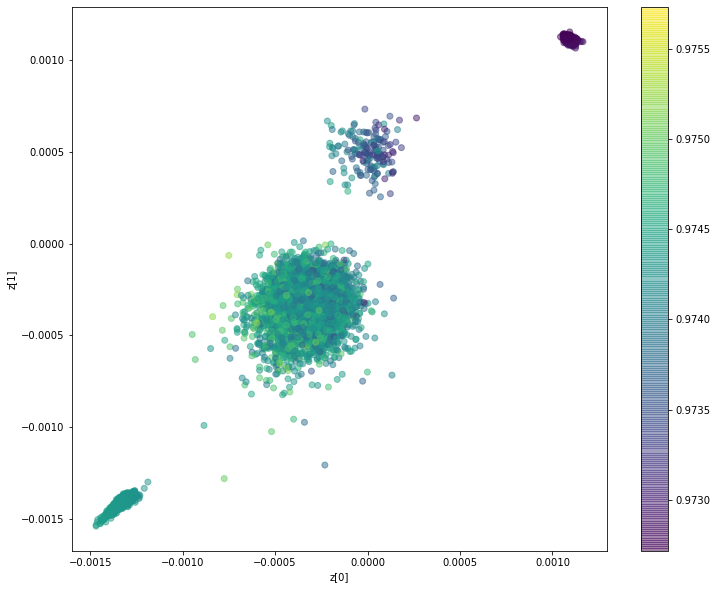

In [10]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=pred_stack.cpu().detach().numpy(), alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [11]:
x = mu_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [12]:
principalDf

,pc1,pc2
0,20.897701,-1.819828
1,20.599945,-2.113010
2,20.537661,-2.322428
3,20.585569,-2.203696
4,20.543289,-2.185059
...,...,...
10011,-8.701655,-0.541213
10012,-8.568215,-0.294109
10013,-8.506290,-0.180489
10014,-8.603040,-0.223160


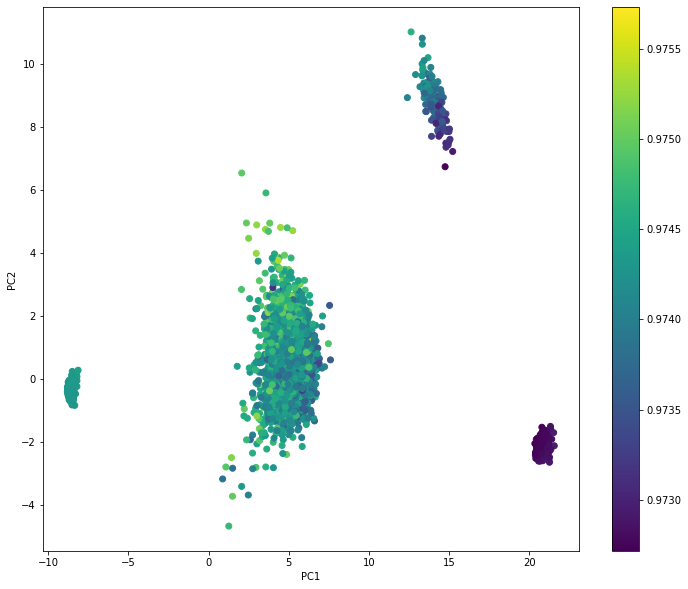

In [14]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=pred_stack.cpu().detach().numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.show()

# Predict property with MLP

In [48]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [49]:
data = dataset.data.iloc[data_sample_index]

In [50]:
labels = torch.tensor(data.logP.values)

In [51]:
MLP_model = MLP()

In [52]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
#loss_fn = F.mse_loss()
latent_output_data = mu_stack

In [54]:
latent_output_data

tensor([[ 1.4013e-45,  0.0000e+00,  5.1844e+22,  ...,  3.0803e-41,
          5.1842e+22,  3.0803e-41],
        [ 5.1843e+22,  3.0803e-41,  2.8026e-45,  ...,  1.3563e-19,
          4.7431e+30,  1.7466e+19],
        [ 2.9087e+32,  1.7220e+22,  1.6020e-19,  ...,  7.1831e+22,
          1.6879e+25,  5.7010e-13],
        ...,
        [-1.0938e-03, -1.0665e-03, -9.9152e-04,  ...,  1.0645e-03,
          1.0949e-03, -9.5291e-04],
        [-1.0242e-03, -1.0672e-03, -9.7669e-04,  ...,  1.0509e-03,
          9.8428e-04, -9.2889e-04],
        [-1.2658e-03, -1.2170e-03, -1.0745e-03,  ...,  1.1769e-03,
          1.1500e-03, -1.0849e-03]], device='cuda:0', grad_fn=<CatBackward0>)

In [55]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 20

for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data[:9984]):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = F.mse_loss(outputs.type(torch.float64), labels[i])
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

<ipython-input-55-9b279a5281ab>:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.type(torch.float64), labels[i])


epoch : 1, train loss : nan
epoch : 2, train loss : nan


KeyboardInterrupt: 

In [43]:
latent_data.size()

torch.Size([100])

In [32]:
labels[i]

tensor(0.9203, dtype=torch.float64)

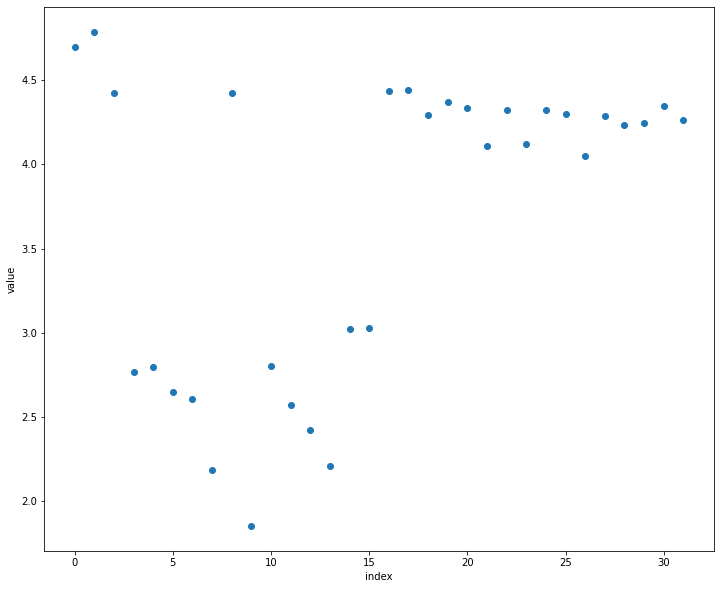

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Property Predictor